# Индивидуальное комплексное задание. Вариант 2

## Банк: Анализ кредитного портфеля и прогнозирование дефолтов

**ФИО студента:** Кравцова Алена Евгеньевна

**Группа:** БД 251м

**Дата:** _____________________

---

### Описание задачи

Вы — аналитик данных в банке. Ваша задача — провести анализ кредитного портфеля и разработать модель для оценки кредитного риска (вероятности дефолта).

**База данных содержит следующие таблицы:**
- `loans` (LoanID, CustomerID, LoanAmount, InterestRate, Term, IssueDate, Status)
- `customers` (CustomerID, Age, Income, CreditScore, EmploymentType, City)
- `payments` (PaymentID, LoanID, PaymentDate, Amount, Status)

**Время выполнения:** 40 минут

---

## Подготовка к работе

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Подключение к базе данных
conn = sqlite3.connect('bank_loans.db')
print("Подключение к базе данных установлено.")

Подключение к базе данных установлено.


---

## Часть 1. Работа с SQL и Pandas (10 минут)

### Задача 1.1 (2 балла)

Напишите SQL-запрос для получения информации о кредитах со статусом **"Default"** (дефолт). Выведите: ID кредита, сумму кредита, процентную ставку, возраст клиента и его кредитный рейтинг.

Загрузите результат в DataFrame `defaulted_loans`.

In [10]:
# Ваш код здесь
query1 = """
SELECT
    l.LoanID AS ID_кредита,
    l.LoanAmount AS Сумма_кредита,
    l.InterestRate AS Процентная_ставка,
    c.Age AS Возраст_клиента,
    c.CreditScore AS Кредитный_рейтинг
FROM loans l
JOIN customers c ON l.CustomerID = c.CustomerID
WHERE Status = 'Default'
ORDER BY l.LoanID;
"""

defaulted_loans = pd.read_sql_query(query1, conn)
display(defaulted_loans)

,ID_кредита,Сумма_кредита,Процентная_ставка,Возраст_клиента,Кредитный_рейтинг
0,11,100000.0,15.10,44,462
1,21,50000.0,24.92,64,489
2,25,200000.0,9.98,44,826
3,34,1500000.0,7.40,57,770
4,40,1000000.0,7.13,38,710
5,42,100000.0,16.97,50,496
6,43,100000.0,10.50,33,606


### Задача 1.2 (3 балла)

Используя `LEFT JOIN`, получите все кредиты с информацией о клиентах. Загрузите в DataFrame `all_loans`.

С помощью Pandas:
1. Создайте новый столбец `DebtToIncome` = `LoanAmount` / `Income` (долговая нагрузка)
2. Рассчитайте средний кредитный рейтинг (`CreditScore`) для каждого типа занятости (`EmploymentType`)
3. Определите, в каком типе занятости самый высокий средний кредитный рейтинг

In [13]:
# Ваш код здесь
query2 = """
SELECT
    l.LoanID,
    l.LoanAmount,
    l.InterestRate,
    l.Status,
    c.CustomerID,
    c.Age,
    c.CreditScore,
    c.Income,
    c.EmploymentType
FROM Loans l
LEFT JOIN customers c ON l.CustomerID = c.CustomerID
ORDER BY l.LoanID;
"""

all_loans = pd.read_sql_query(query2, conn)

# Создание нового столбца DebtToIncome
all_loans['DebtToIncome'] = all_loans['LoanAmount'] / all_loans['Income']

# Анализ по типу занятости - средний кредитный рейтинг для каждого типа занятости
avg_credit_by_employment = all_loans.groupby('EmploymentType')['CreditScore'].mean().reset_index()

# Определяем тип занятости с самым высоким средним кредитным рейтингом
# Сортируем по убыванию среднего кредитного рейтинга
avg_credit_by_employment = avg_credit_by_employment.sort_values('CreditScore', ascending=False)

# Самый высокий средний кредитный рейтинг
highest_avg_credit = avg_credit_by_employment.iloc[0]

print(f"DataFrame all_loans создан, размер: {all_loans.shape}")
print(f"Самый высокий средний кредитный рейтинг: {highest_avg_credit['EmploymentType']} ({highest_avg_credit['CreditScore']:.2f})")

display(all_loans.head())

DataFrame all_loans создан, размер: (50, 10)
Самый высокий средний кредитный рейтинг: Государственный служащий (696.00)


,LoanID,LoanAmount,InterestRate,Status,CustomerID,Age,CreditScore,Income,EmploymentType,DebtToIncome
0,1,1000000.0,19.13,Active,15,64,489,113084.0,Частичная занятость,8.842984
1,2,1500000.0,7.64,Active,4,30,845,149923.0,Государственный служащий,10.005136
2,3,200000.0,19.78,Paid,15,64,489,113084.0,Частичная занятость,1.768597
3,4,1000000.0,18.67,Paid,9,50,496,172669.0,Самозанятый,5.791428
4,5,200000.0,19.53,Active,23,44,496,117068.0,Частичная занятость,1.708409


---

## Часть 2. Исследовательский анализ данных (EDA) (10 минут)

### Задача 2.1 (2 балла)

Используя DataFrame `all_loans`:
1. Выведите описательную статистику для столбцов `CreditScore` и `InterestRate`
2. Постройте **гистограмму** распределения кредитных рейтингов
3. Постройте **boxplot** для процентных ставок в разрезе статуса кредита (`Status`)

       CreditScore  InterestRate
count    50.000000     50.000000
mean    575.340000     13.679200
std     142.637204      4.923418
min     320.000000      6.220000
25%     491.500000     10.417500
50%     572.500000     13.345000
75%     637.000000     17.705000
max     845.000000     24.920000


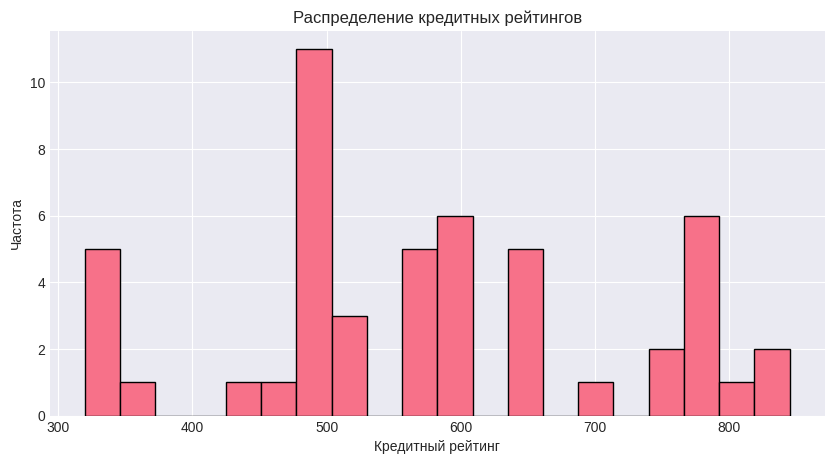

<Figure size 1000x500 with 0 Axes>

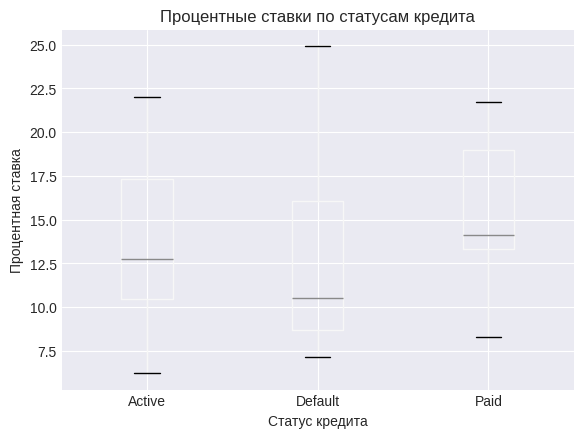

In [14]:
# Задача 2.1
# Описательная статистика
print(all_loans[['CreditScore', 'InterestRate']].describe())

# Гистограмма распределения кредитных рейтингов
plt.figure(figsize=(10, 5))
plt.hist(all_loans['CreditScore'], bins=20, edgecolor='black')
plt.title('Распределение кредитных рейтингов')
plt.xlabel('Кредитный рейтинг')
plt.ylabel('Частота')
plt.show()

# Boxplot для процентных ставок по статусам кредита
plt.figure(figsize=(10, 5))
all_loans.boxplot(column='InterestRate', by='Status')
plt.title('Процентные ставки по статусам кредита')
plt.suptitle('')  # Убираем автоматический заголовок
plt.xlabel('Статус кредита')
plt.ylabel('Процентная ставка')
plt.show()

### Задача 2.2 (3 балла)

**Бизнес-гипотеза:** "Клиенты с более низким кредитным рейтингом имеют более высокую процентную ставку."

1. Постройте **scatter plot** с `CreditScore` по оси X и `InterestRate` по оси Y
2. Рассчитайте коэффициент корреляции между этими переменными
3. Сделайте вывод: подтверждается ли гипотеза? Какие бизнес-решения это может повлечь?

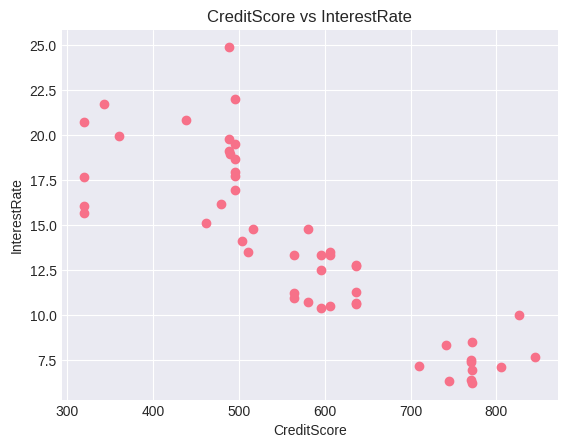

Корреляция: -0.8435548853869883
Гипотеза подтверждается: сильная отрицательная корреляция


In [15]:
# Задача 2.2

# Scatter plot
plt.scatter(all_loans['CreditScore'], all_loans['InterestRate'])
plt.title('CreditScore vs InterestRate')
plt.xlabel('CreditScore')
plt.ylabel('InterestRate')
plt.show()

# Корреляция
corr = all_loans['CreditScore'].corr(all_loans['InterestRate'])
print(f"Корреляция: {corr}")

# Вывод
if corr < -0.3:
    print("Гипотеза подтверждается: сильная отрицательная корреляция")
elif corr < 0:
    print("Гипотеза подтверждается: слабая отрицательная корреляция")
else:
    print("Гипотеза не подтверждается")

---

## Часть 3. Анализ временных рядов (10 минут)

### Задача 3.1 (3 балла)

Получите из базы данных ежемесячную статистику выдачи кредитов (дата и сумма выданных кредитов).

1. Преобразуйте столбец с датой в формат `datetime`
2. Выполните **ресэмплинг** в месячные агрегаты (общая сумма выданных кредитов за месяц)
3. Постройте **линейный график** динамики выдачи кредитов по месяцам
4. Извлеките признак "квартал" и определите, в каком квартале выдается больше всего кредитов

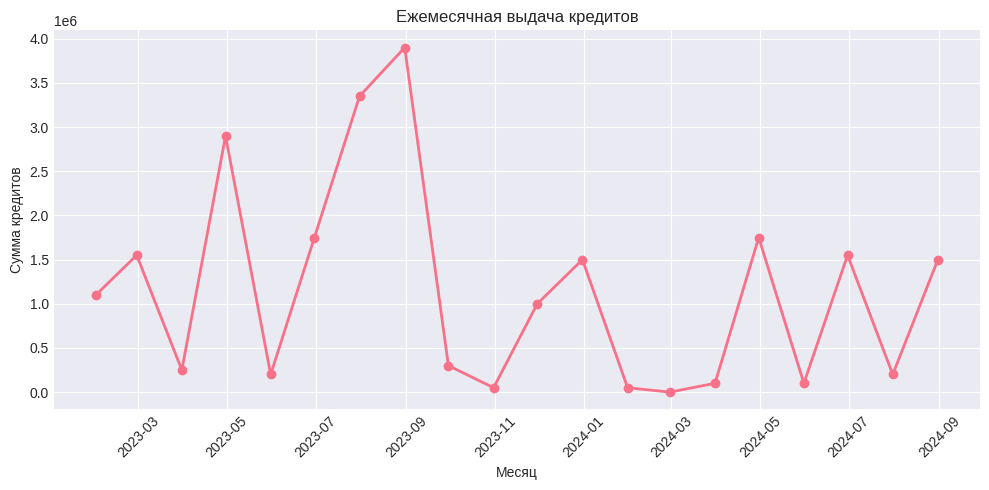

Сумма кредитов по кварталам:
Quarter
1    3050000.0
2    8250000.0
3    9250000.0
4    2550000.0
Name: LoanAmount, dtype: float64


In [21]:
# Ваш код здесь
query3 = """
SELECT
    IssueDate,
    LoanAmount
FROM Loans
ORDER BY IssueDate;
"""

monthly_loans = pd.read_sql_query(query3, conn)

# Преобразование даты и ресэмплинг
monthly_loans['IssueDate'] = pd.to_datetime(monthly_loans['IssueDate'])
monthly_stats = monthly_loans.set_index('IssueDate').resample('M')['LoanAmount'].sum()

# График
plt.figure(figsize=(10, 5))
plt.plot(monthly_stats.index, monthly_stats.values, marker='o', linewidth=2)
plt.title('Ежемесячная выдача кредитов')
plt.xlabel('Месяц')
plt.ylabel('Сумма кредитов')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Анализ по кварталам
monthly_loans['Quarter'] = monthly_loans['IssueDate'].dt.quarter
quarterly_stats = monthly_loans.groupby('Quarter')['LoanAmount'].sum()

print("Сумма кредитов по кварталам:")
print(quarterly_stats)

max_quarter = quarterly_stats.idxmax()
max_amount = quarterly_stats.max()

### Задача 3.2 (2 балла)

Для прогнозирования объемов выдачи создайте:
1. `Loans_Lag1` — сумма выданных кредитов за предыдущий месяц
2. `Rolling_Mean_3` — скользящее среднее за 3 месяца

Удалите строки с пропущенными значениями и выведите первые 5 строк результирующего DataFrame.

In [22]:
# Ваш код здесь
# Лаговые признаки и скользящее среднее
monthly_stats_df = monthly_stats.reset_index()
monthly_stats_df.columns = ['Month', 'Total_Loan_Amount']

# Lag1 - сумма за предыдущий месяц
monthly_stats_df['Loans_Lag1'] = monthly_stats_df['Total_Loan_Amount'].shift(1)

# Rolling Mean за 3 месяца
monthly_stats_df['Rolling_Mean_3'] = monthly_stats_df['Total_Loan_Amount'].rolling(window=3).mean()

# Удаление NaN
monthly_stats_clean = monthly_stats_df.dropna()

display(monthly_stats_clean.head())

,Month,Total_Loan_Amount,Loans_Lag1,Rolling_Mean_3
2,2023-03-31,250000.0,1550000.0,9.666667e+05
3,2023-04-30,2900000.0,250000.0,1.566667e+06
4,2023-05-31,200000.0,2900000.0,1.116667e+06
5,2023-06-30,1750000.0,200000.0,1.616667e+06
6,2023-07-31,3350000.0,1750000.0,1.766667e+06


---

## Часть 4. Построение модели классификации (10 минут)

### Задача 4.1 (3 балла)

Постройте модель **логистической регрессии** для предсказания дефолта кредита.

1. Используйте признаки: `CreditScore`, `DebtToIncome`, `InterestRate`, `Age`
2. Целевая переменная: `IsDefault` (1 если Status='Default', иначе 0)
3. Разделите данные на обучающую (80%) и тестовую (20%) выборки
4. Обучите модель `LogisticRegression`
5. Сделайте предсказания на тестовой выборке

In [24]:
# Ваш код здесь
# Создание целевой переменной
all_loans['IsDefault'] = (all_loans['Status'] == 'Default').astype(int)

# Определение X и y
X = all_loans[['CreditScore', 'DebtToIncome', 'InterestRate', 'Age']]
y = all_loans['IsDefault']

# Разделение на train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество дефолтов в тестовой выборке: {y_test.sum()} из {len(y_test)}")
print(f"Количество предсказанных дефолтов: {y_pred.sum()} из {len(y_pred)}")


Размер обучающей выборки: (40, 4)
Размер тестовой выборки: (10, 4)
Количество дефолтов в тестовой выборке: 1 из 10
Количество предсказанных дефолтов: 0 из 10


### Задача 4.2 (2 балла)

Оцените качество модели:
1. Рассчитайте **Accuracy**
2. Постройте **матрицу ошибок** (confusion matrix)
3. Выведите **classification report** (precision, recall, f1-score)
4. Сделайте бизнес-вывод: какие ошибки (ложноположительные или ложноотрицательные) более критичны для банка и почему?

In [25]:
# Оценка качества модели
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nМатрица ошибок:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9000

Матрица ошибок:
[[9 0]
 [1 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.00      0.00      0.00         1

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10


Бизнес-вывод:
Для банка более критичны ложноотрицательные ошибки (когда модель предсказывает
не-дефолт, а на самом деле клиент уходит в дефолт). Причина:
1. Банк теряет реальные деньги при непредсказанном дефолте
2. Ложноположительные ошибки (отказ выдать кредит надежному клиенту)
   ведут лишь к упущенной выгоде, а не к прямым убыткам


---

## Закрытие подключения

In [26]:
conn.close()
print("Подключение к базе данных закрыто.")

Подключение к базе данных закрыто.


---

## Критерии оценки

| Часть | Максимальный балл |
|-------|-------------------|
| Часть 1: SQL и Pandas | 5 баллов |
| Часть 2: EDA | 5 баллов |
| Часть 3: Временные ряды | 5 баллов |
| Часть 4: ML | 5 баллов |
| **ИТОГО** | **20 баллов** |

---

**Файл должен быть сохранен с именем:** `Фамилия_Вариант2.ipynb`